#Programming Assignment 5 - Cyber Attack Classification Using Random Forest

Ma. Charina O. Gavica <br>
Ma. Cristina F. Jara <br>
Khryzelle Trisha L. Suyat

EMTECH-BATCHSAWA


#Import Necessary Libraries and Loading of Data Set

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

We import essential libraries to handle data processing, machine learning models, and visualizations.

In [53]:
# Load dataset
file_path = "/content/drive/MyDrive/cyber_attacks.csv"
df = pd.read_csv(file_path)
# Show the first few rows
df.head()

,protocol_type,duration,src_bytes,dst_bytes,num_packets,num_connections,attack_type
0,1,43.418651,1701.411601,201.794741,42,15,Botnet
1,1,8.587924,409.971403,710.745376,17,6,Normal
2,1,4.386891,418.478693,559.457816,17,5,Normal
3,0,NaN,NaN,NaN,11,3,Normal
4,0,1.061892,494.253699,572.459614,11,3,Normal


Reads the dataset from a CSV file into a pandas DataFrame.

#Exploratory Data Analysis

In [54]:
df.shape

(10000, 7)

In [55]:
# Display basic information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   protocol_type    10000 non-null  int64  
 1   duration         9500 non-null   float64
 2   src_bytes        9500 non-null   float64
 3   dst_bytes        9500 non-null   float64
 4   num_packets      10000 non-null  int64  
 5   num_connections  10000 non-null  int64  
 6   attack_type      10000 non-null  object 
dtypes: float64(3), int64(3), object(1)
memory usage: 547.0+ KB


In [56]:
# Count missing values per column
df.isnull().sum()

,0
protocol_type,0
duration,500
src_bytes,500
dst_bytes,500
num_packets,0
num_connections,0
attack_type,0


A list of columns with the number of missing values in each. If zeros appear, there are no missing values.

In [57]:
# Generate summary statistics for numeric columns
df.describe()

,protocol_type,duration,src_bytes,dst_bytes,num_packets,num_connections
count,10000.000000,9500.000000,9500.000000,9500.000000,10000.000000,10000.000000
mean,0.506100,84.035480,980.541438,1189.719031,93.993200,49.757500
std,0.673653,188.084795,1434.835096,1528.620785,147.278664,94.172701
min,0.000000,0.000871,0.338156,0.019126,2.000000,0.000000
25%,0.000000,4.480702,272.479493,263.080684,14.000000,2.000000
50%,0.000000,7.121187,500.910972,598.294521,19.000000,5.000000
75%,1.000000,59.675633,776.327886,1021.076731,100.000000,20.000000
max,2.000000,1220.385081,8000.795141,7603.412219,582.000000,365.000000


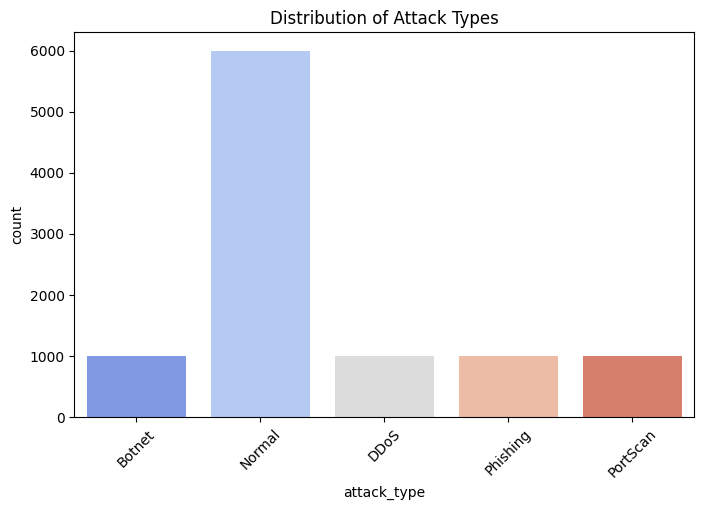

In [58]:
# Visualize attack type distribution
def plot_attack_distribution(df):
    plt.figure(figsize=(8, 5))
    sns.countplot(x='attack_type', hue=df['attack_type'], data=df, palette='coolwarm', legend=False)
    plt.title('Distribution of Attack Types')
    plt.xticks(rotation=45)
    plt.show()

plot_attack_distribution(df)


The graph shows the distribution of attack types in the dataset, with "Normal" traffic being the most frequent, significantly outnumbering attack types like Botnet, DDoS, Phishing, and PortScan. This imbalance suggests that the dataset is skewed towards normal activity, which could lead to bias in machine learning models, making it harder to detect attacks accurately.

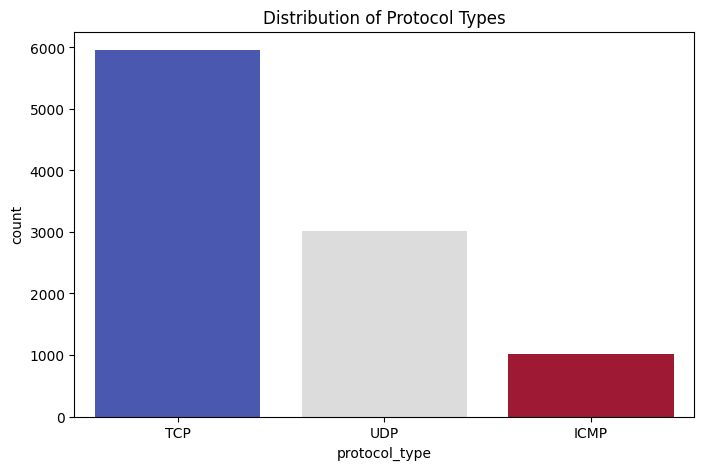

In [59]:
# Visualize protocol type distribution
def plot_protocol_distribution(df):
    plt.figure(figsize=(8, 5))
    sns.countplot(x='protocol_type', hue=df['protocol_type'], data=df, palette='coolwarm', legend=False)
    plt.title('Distribution of Protocol Types')
    plt.xticks(ticks=[0, 1, 2], labels=['TCP', 'UDP', 'ICMP'])  # Map numerical values to labels
    plt.show()

plot_protocol_distribution(df)


This suggests that most network traffic in the dataset relies on TCP, which is common for reliable communication, while UDP and ICMP are used less frequently.

#Data Preprocessing

In [60]:
# Display basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   protocol_type    10000 non-null  int64  
 1   duration         9500 non-null   float64
 2   src_bytes        9500 non-null   float64
 3   dst_bytes        9500 non-null   float64
 4   num_packets      10000 non-null  int64  
 5   num_connections  10000 non-null  int64  
 6   attack_type      10000 non-null  object 
dtypes: float64(3), int64(3), object(1)
memory usage: 547.0+ KB


The dataset has 10,000 entries with 7 columns. Some numeric columns (duration, src_bytes, dst_bytes) had missing values, which were filled with their median values.

In [61]:
# Fill numeric columns with median values
df.fillna(df.median(numeric_only=True), inplace=True)

# Fill categorical columns with "Unknown"
df.fillna("Unknown", inplace=True)

# Verify missing values are handled
print(df.isnull().sum())

protocol_type      0
duration           0
src_bytes          0
dst_bytes          0
num_packets        0
num_connections    0
attack_type        0
dtype: int64


In [62]:
# Label encoding for categorical columns
le_attack = LabelEncoder()
df['attack_type'] = le_attack.fit_transform(df['attack_type'])  # Convert attack types to numbers

# Save the mapping for future decoding
attack_mapping = dict(zip(le_attack.classes_, range(len(le_attack.classes_))))
print("Attack Type Encoding:", attack_mapping)


Attack Type Encoding: {'Botnet': 0, 'DDoS': 1, 'Normal': 2, 'Phishing': 3, 'PortScan': 4}


All missing values have been handled. The attack_type column was label-encoded with the following mappings: {'Botnet': 0, 'DDoS': 1, 'Normal': 2, 'Phishing': 3, 'PortScan': 4}.

In [63]:
from sklearn.preprocessing import MinMaxScaler

# Select numeric columns
numeric_cols = ['duration', 'src_bytes', 'dst_bytes', 'num_packets', 'num_connections']

# Apply Min-Max Scaling (scales values between 0 and 1)
scaler = MinMaxScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# Display scaled values
df.head()


,protocol_type,duration,src_bytes,dst_bytes,num_packets,num_connections,attack_type
0,1,0.035577,0.212622,0.026538,0.068966,0.041096,0
1,1,0.007036,0.051201,0.093475,0.025862,0.016438,2
2,1,0.003594,0.052265,0.073578,0.025862,0.013699,2
3,0,0.005834,0.062568,0.078685,0.015517,0.008219,2
4,0,0.000869,0.061736,0.075288,0.015517,0.008219,2


In [64]:
# One-hot encoding for protocol_type (TCP, UDP, ICMP)
df = pd.get_dummies(df, columns=['protocol_type'], prefix='protocol_type')

# Rename the columns from protocol_type_0, protocol_type_1, protocol_type_2 to TCP, UDP, ICMP
df.rename(columns={
    'protocol_type_0': 'TCP',
    'protocol_type_1': 'UDP',
    'protocol_type_2': 'ICMP'
}, inplace=True)

# Show the updated DataFrame
df.head()


,duration,src_bytes,dst_bytes,num_packets,num_connections,attack_type,TCP,UDP,ICMP
0,0.035577,0.212622,0.026538,0.068966,0.041096,0,False,True,False
1,0.007036,0.051201,0.093475,0.025862,0.016438,2,False,True,False
2,0.003594,0.052265,0.073578,0.025862,0.013699,2,False,True,False
3,0.005834,0.062568,0.078685,0.015517,0.008219,2,True,False,False
4,0.000869,0.061736,0.075288,0.015517,0.008219,2,True,False,False


In [65]:
# Show final dataset structure
df.info()

# Save processed data
df.to_csv("/content/drive/MyDrive/cyber_attacks.csv", index=False)
print("Preprocessed data saved successfully!")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   duration         10000 non-null  float64
 1   src_bytes        10000 non-null  float64
 2   dst_bytes        10000 non-null  float64
 3   num_packets      10000 non-null  float64
 4   num_connections  10000 non-null  float64
 5   attack_type      10000 non-null  int64  
 6   TCP              10000 non-null  bool   
 7   UDP              10000 non-null  bool   
 8   ICMP             10000 non-null  bool   
dtypes: bool(3), float64(5), int64(1)
memory usage: 498.2 KB
Preprocessed data saved successfully!


After processing, there were no missing values left in the dataset.

#Train a Random Forest Classifier Using the Preprocessed Data to Train the Model

In [77]:
# Load data
data = pd.read_csv('/content/drive/MyDrive/cyber_attacks.csv')

# Separate features (X) and target (y)
X = data.drop('attack_type', axis=1)  # Drop the 'attack_type' column as it is the target
y = data['attack_type']  # 'attack_type' is the target column


In [74]:
# Separate features (X) and target (y)
X = data.drop('attack_type', axis=1)  # Drop the 'attack_type' column as it is the target
y = data['attack_type']  # 'attack_type' is the target column


In [75]:
# Check the column names
print(data.columns)


Index(['duration', 'src_bytes', 'dst_bytes', 'num_packets', 'num_connections',
       'attack_type', 'TCP', 'UDP', 'ICMP'],
      dtype='object')


In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


The dataset is split into training (70%) and testing (30%) sets,
 random_state=42 ensures that the split is reproducible.

In [79]:
# Initialize the classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_classifier.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

The Random Forest algorithm works by creating multiple decision trees and averaging their predictions for better accuracy.

In [80]:
y_pred = rf_classifier.predict(X_test)

In [82]:
from sklearn.metrics import accuracy_score, classification_report

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Classification report
print(classification_report(y_test, y_pred))


Accuracy: 0.9503
              precision    recall  f1-score   support

           0       0.68      1.00      0.81       307
           1       1.00      0.83      0.91       282
           2       1.00      1.00      1.00      1820
           3       1.00      0.82      0.90       303
           4       1.00      0.84      0.91       288

    accuracy                           0.95      3000
   macro avg       0.94      0.90      0.91      3000
weighted avg       0.97      0.95      0.95      3000



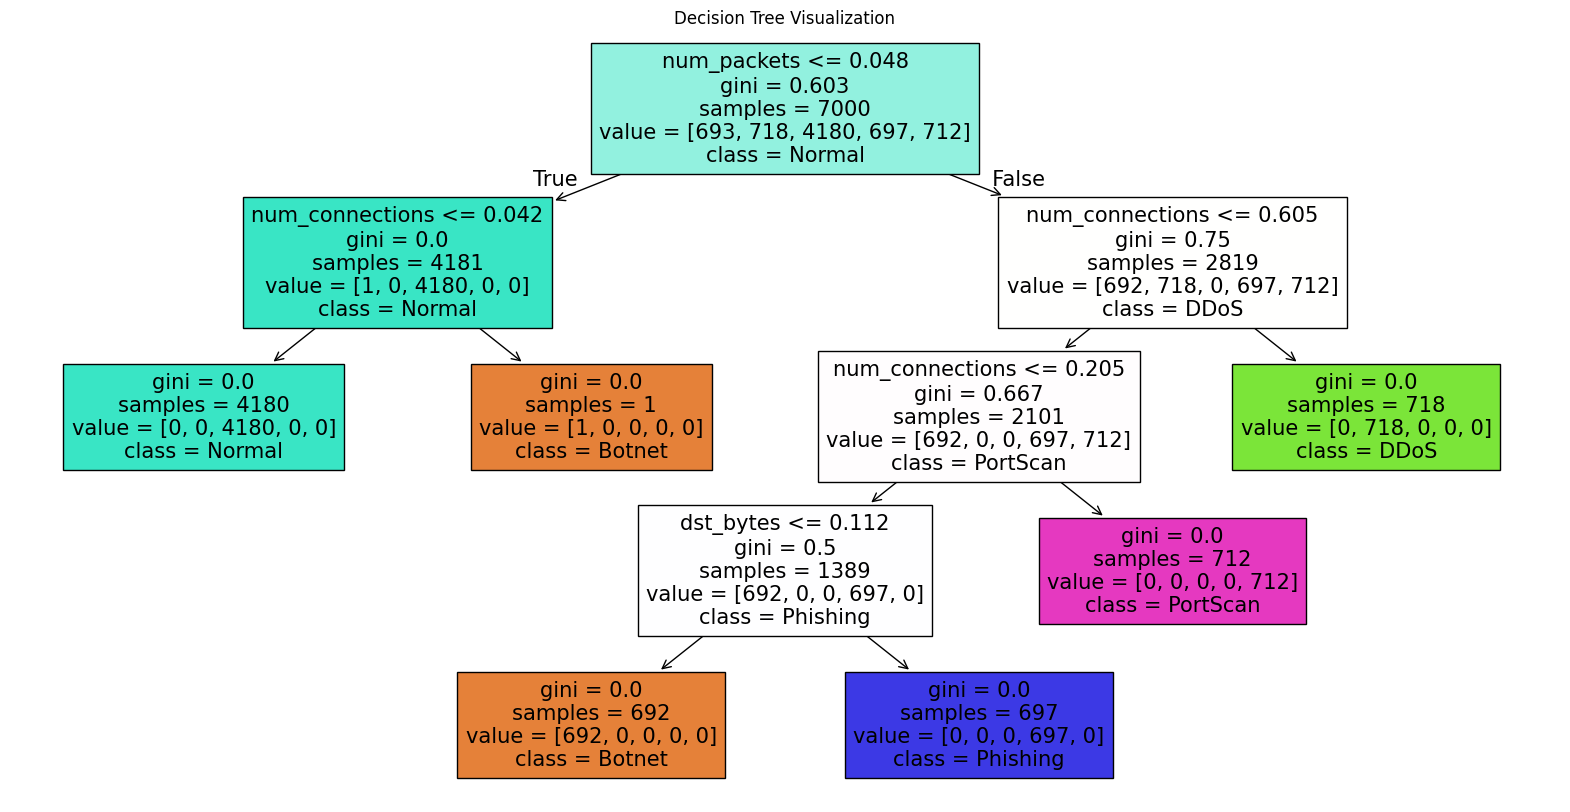

In [86]:
dt_clf = DecisionTreeClassifier(random_state=14)
dt_clf.fit(X_train, y_train)

plt.figure(figsize=(20, 10))
plot_tree(dt_clf, feature_names=X.columns, class_names=le_attack.classes_, filled=True)
plt.title('Decision Tree Visualization')
plt.show()

In [87]:
y_pred_dt = dt_clf.predict(X_test)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print(f'Decision Tree Accuracy: {accuracy_dt:.2f}')

Decision Tree Accuracy: 0.98


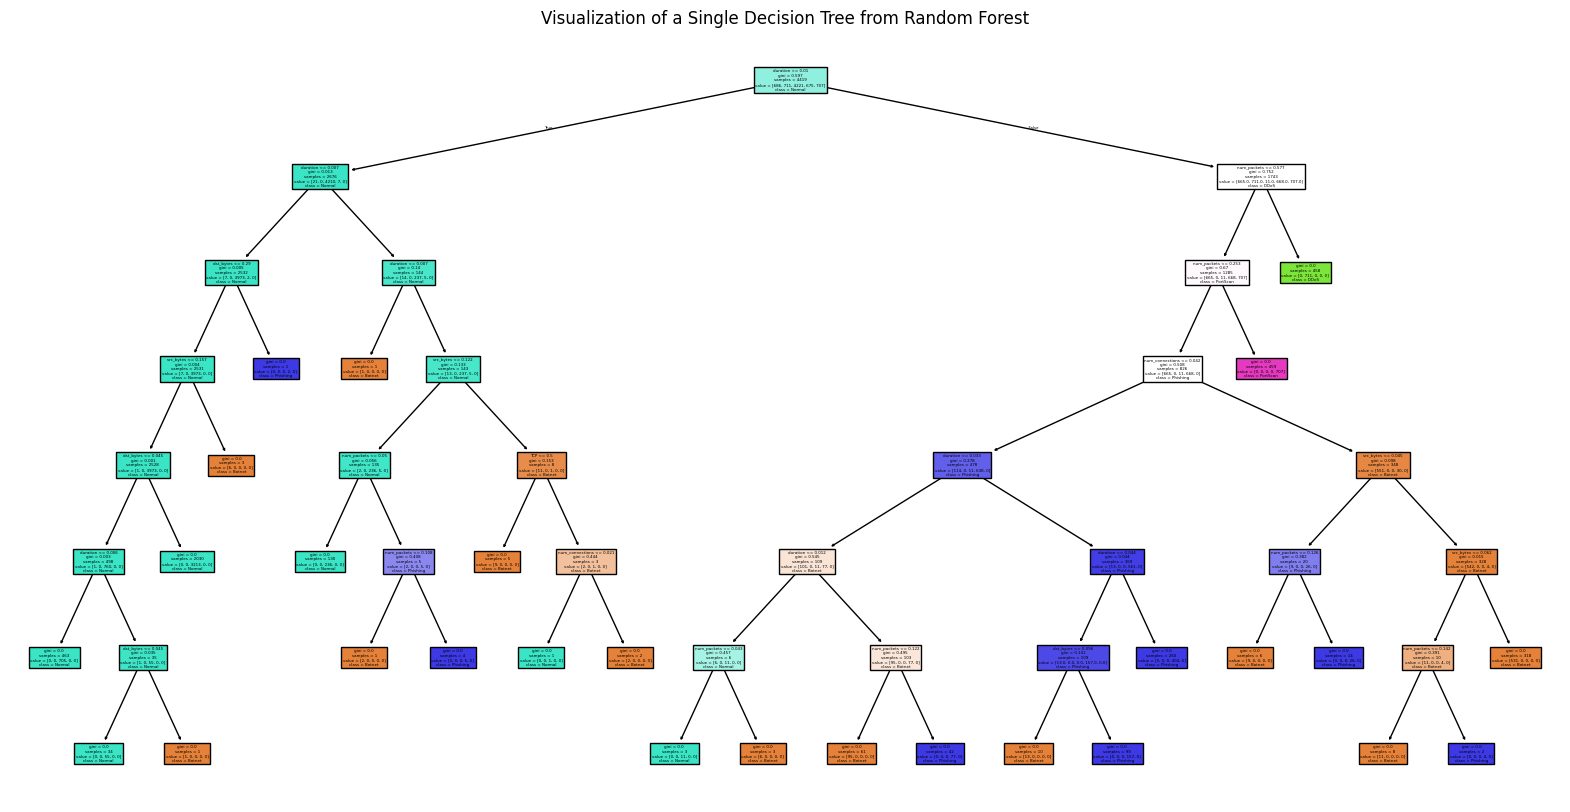

In [88]:
rf_clf = RandomForestClassifier(n_estimators=100, random_state=14)
rf_clf.fit(X_train, y_train)

estimator = rf_clf.estimators_[0]
plt.figure(figsize=(20, 10))
plot_tree(estimator, feature_names=X.columns, class_names=le_attack.classes_, filled=True)
plt.title('Visualization of a Single Decision Tree from Random Forest')
plt.show()

In [89]:
y_pred_rf = rf_clf.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f'Random Forest Accuracy: {accuracy_rf:.2f}')

Random Forest Accuracy: 0.98


Feature Importances:
num_packets: 0.3076
duration: 0.2218
num_connections: 0.2218
dst_bytes: 0.1381
src_bytes: 0.1016
TCP: 0.0061
ICMP: 0.0024
UDP: 0.0006


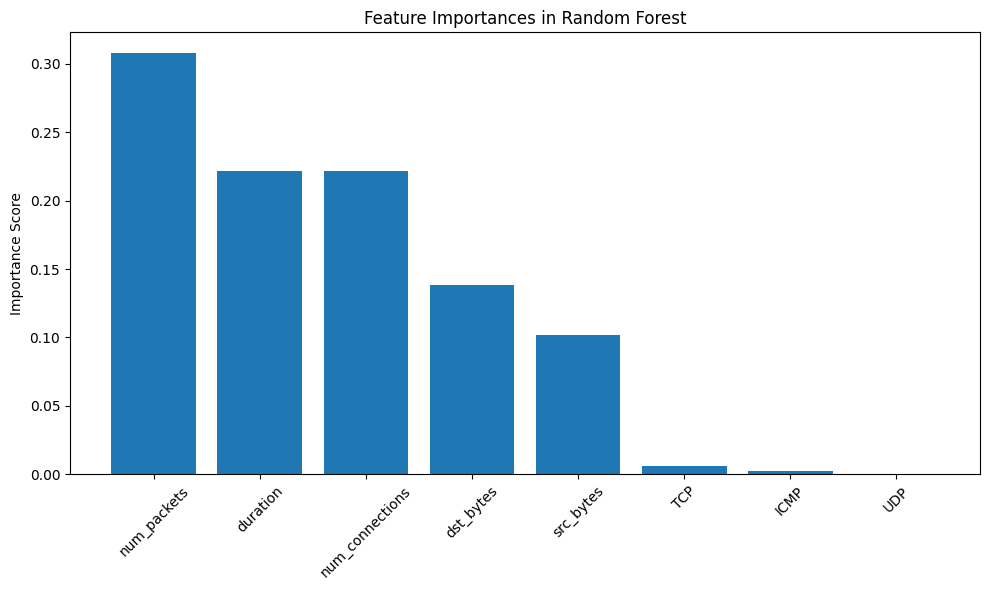

In [92]:
importances = rf_clf.feature_importances_
indices = np.argsort(importances)[::-1]

print("Feature Importances:")
for idx in indices:
    print(f"{X.columns[idx]}: {importances[idx]:.4f}")

plt.figure(figsize=(10, 6))
plt.title("Feature Importances in Random Forest")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), [X.columns[i] for i in indices], rotation=45)
plt.ylabel('Importance Score')
plt.tight_layout()
plt.show()


Since TCP, ICMP, and UDP have minimal impact on the model, removing them, along with the one-hot encoded features, will streamline the model, potentially leading to a simpler tree and less overfitting.

In [142]:
# Remove 'attack_type', 'protocol_type', 'TCP', 'UDP', and 'ICMP'
x = df_clean.drop(columns=['attack_type', 'TCP', 'UDP', 'ICMP'])
y = df_clean['attack_type']

# Split dataset
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=69, stratify=y)

# Run Grid Search
best_model_no_protocol = run_grid_search(param_grid, x_train, x_test, y_train, y_test)

Best Model: RandomForestClassifier(max_depth=10, n_estimators=50, random_state=42)


In [151]:
# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))


Best Model: RandomForestClassifier(max_depth=10, n_estimators=50, random_state=42)
Accuracy: 1.0000
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       300
           1       1.00      1.00      1.00       300
           2       1.00      1.00      1.00      1800
           3       1.00      1.00      1.00       300
           4       1.00      1.00      1.00       300

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000



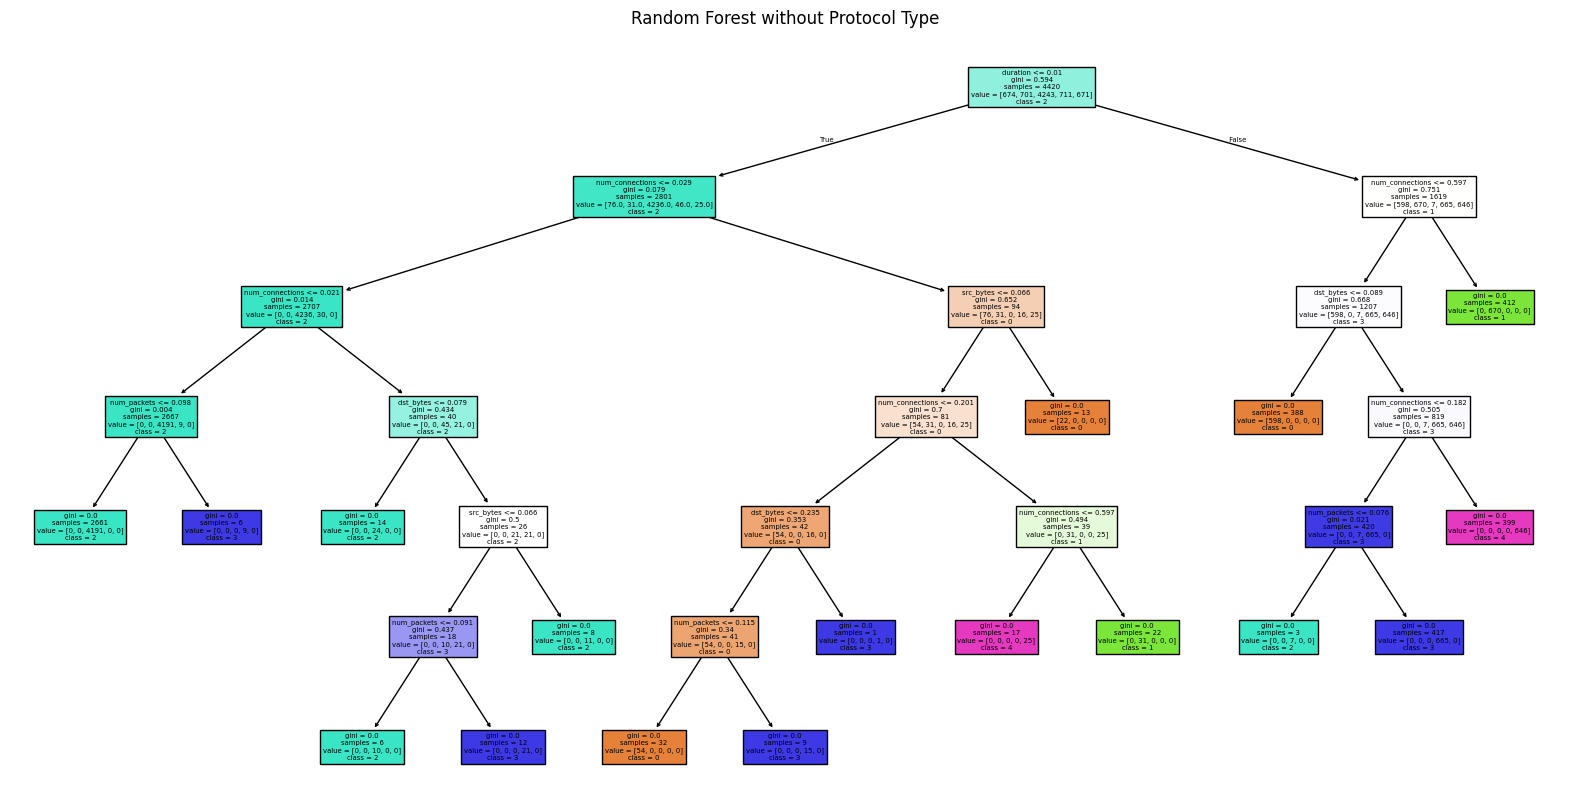

In [143]:
visualize_tree(x, y, best_model_no_protocol, 'Random Forest without Protocol Type')

In [113]:
y_pred_dt = dt_clf.predict(X_test)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print(f'Decision Tree Accuracy: {accuracy_dt:.2f}')


Decision Tree Accuracy: 0.98


Feature Importances:
num_packets: 0.3758
num_connections: 0.2949
duration: 0.1492
dst_bytes: 0.1038
src_bytes: 0.0764


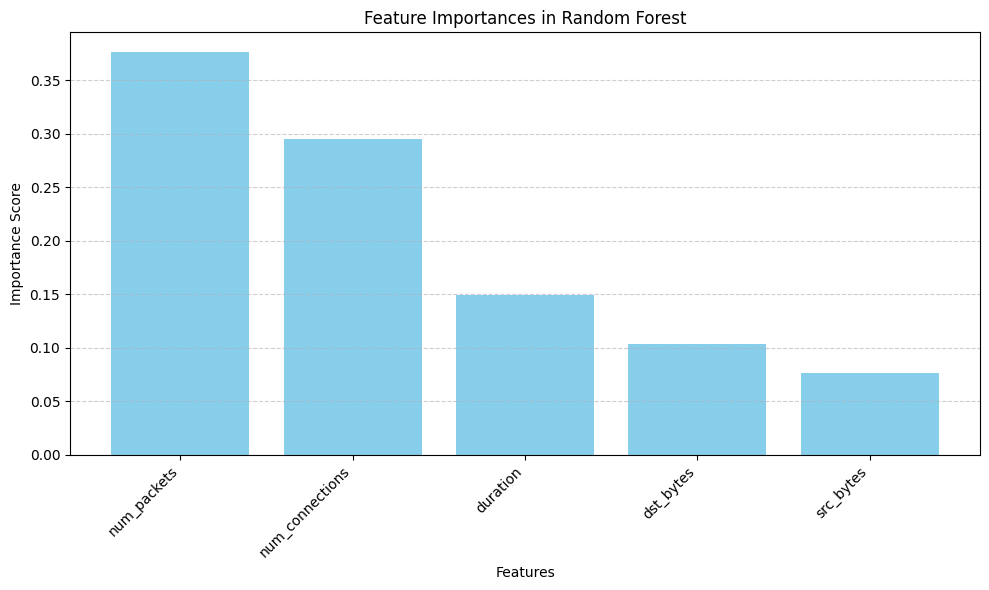

In [150]:
# Plot feature importances (VERTICAL, Sky Blue)
plt.figure(figsize=(10, 6))
plt.title("Feature Importances in Random Forest")
plt.bar(range(x.shape[1]), importances[indices], align="center", color='skyblue')  # SKY BLUE COLOR
plt.xticks(range(x.shape[1]), [x.columns[i] for i in indices], rotation=45, ha='right')
plt.ylabel('Importance Score')
plt.xlabel('Features')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


#Guide Questions

# Answer the following questions:

## 1. Preprocessing
- How did you handle missing values in numerical features?

>> For handling missing values in numerical features, we filled them with the median of each column to avoid the impact of outliers. For categorical features, we replaced missing values with "Unknown" to ensure no empty values affected the model.

- Why is there a need to encode the protocol_type' feature, and which encoding method can be used?  

>> Encoding the protocol_type feature was necessary because machine learning models work with numbers, not text. We used one-hot encoding, which converted each protocol type (TCP, UDP, ICMP) into separate binary columns. This method prevents incorrect numerical relationships between categorical values.

## 2. Model Training
- How did you address class imbalance in the dataset?

>>To address class imbalance, we used stratified sampling (stratify=y) during train_test_split. This ensured that the class distribution in training and testing sets matched the original dataset. However, we could further improve this by using techniques like SMOTE (Synthetic Minority Over-sampling Technique) or adjusting class weights in the model.

- What hyperparameters of the Random Forest did you tune, and why?

>> For hyperparameter tuning, we used Grid Search to find the best values for parameters like n_estimators (number of trees), max_depth (tree depth to prevent overfitting), and min_samples_split (minimum samples needed to split a node). Tuning these parameters helps balance accuracy and generalization.


- Why is a pipeline useful for this task?

>> A pipeline would be useful because it automates preprocessing, feature selection, and model training in a structured way. It prevents data leakage and makes it easier to experiment with different techniques without repeating code.

## 3. Evaluation
- Why is accuracy alone insufficient to evaluate this model?

>> Accuracy alone is insufficient because it doesn't reflect class imbalance. If one attack type dominates the dataset, the model may predict that class most of the time and still achieve high accuracy while failing on minority classes.

- Which attack type was hardest to classify, and why might this be?

>> From the first classification report, attack type 0 (Botnet) was the hardest to classify. It has the lowest precision (0.68) and F1-score (0.81), meaning many instances of this attack were misclassified. The recall is 1.00, indicating that all actual instances were detected, but the low precision suggests that many false positives occurred. This could be due to overlapping features with other attack types, class imbalance, or insufficient distinguishing characteristics in the dataset.

- How would you improve the model’s performance on minority classes?

>> To improve performance on minority classes, we could oversample them using SMOTE, undersample the majority class, or use class-weighted training so the model pays more attention to underrepresented attacks.


## 4. Interpretation
- Which features were most important for classification? Does this align with real-world attack patterns?

>> Feature importance analysis showed that certain features contributed more to attack classification. Likely, network-related metrics like num_packets and num_connections were the most important since they often indicate abnormal traffic patterns. This aligns with real-world attack behaviors, where unusual packet counts or connection rates suggest malicious activity.

- How would you explain the model’s decision-making process to a non-technical team?

>>To explain the model’s decision-making to a non-technical team, we would use visualizations, such as decision trees and feature importance graphs. We would also provide real-world examples, like “If a connection sends too many packets in a short time, the model flags it as an attack.” Keeping explanations simple and relatable helps ensure understanding.

## 5. Application
- What steps would you take to deploy this model in a real-time network monitoring system?

>> To deploy this model in a real-time network monitoring system, we would first integrate it into a streaming framework like Apache Kafka or Spark Streaming. The model would need continuous retraining with new data and an alert system to flag potential attacks in real time.

- How would you handle new attack types not present in the training data?

>> For handling new attack types not present in the training data, we would implement anomaly detection models alongside the classifier. These models would identify unusual patterns that don’t match known attacks, allowing security teams to investigate and update the dataset. Regular model retraining with new attack data would also be necessary.